In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import glob
from tqdm import tqdm
import h5py as h5
import ast
import os
import corner
import Pk_library as PKL
import MAS_library as MASL
from contextlib import contextmanager
import sys
import symbolic_pofk.linear

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
def get_mcmc_steps(dirname, nframe, iter_max, iter_min=0):
    """
    Obtain evenly-spaced sample of MCMC steps to make movie from
    """
    all_mcmc = glob.glob(dirname + '/mcmc_*.h5')
    x = [m[len(dirname + '/mcmc_'):-3] for m in all_mcmc]
    all_mcmc = np.sort([int(m[len(dirname + '/mcmc_'):-3]) for m in all_mcmc])
    if iter_max >= 0:
        all_mcmc = all_mcmc[all_mcmc <= iter_max]
    all_mcmc = all_mcmc[all_mcmc >= iter_min]
    if nframe > 0:
        max_out = max(all_mcmc)
        min_out = min(all_mcmc)
        step = max(int((max_out - min_out+1) / nframe), 1)
        all_mcmc = all_mcmc[::step]
        if max_out not in all_mcmc:
            all_mcmc = np.concatenate([all_mcmc, [max_out]])
    return all_mcmc

def load_param_samples(ini_name, dirname, nframe, iter_max, iter_min):
    
    config = configparser.ConfigParser()
    config.read(ini_name)
    to_sample = []
    for k,v in config['block_loop'].items():
        if v.strip() == 'false':
            i = k.index('_sampler')
            if k[:i] not in ['hades', 'bias', 'nmean']:
                to_sample.append(k[:i])
                
    print("TO SAMPLE", to_sample)
    nsamp = int(config['run']['nsamp'])
    new_to_sample = []
    for s in to_sample:
        if s in ['omega_m', 'sigma8', 'sig_v']:
            new_to_sample.append(s)
        elif s == 'bulk_flow':
            for d in ['_x', '_y', '_z']:
                new_to_sample.append(f'{s}{d}')
        else:
            for i in range(nsamp):
                new_to_sample.append(f'{s}{i}')
    
    # This is desired list to sample
    to_sample = new_to_sample
    
    # Which steps to use
    all_mcmc = get_mcmc_steps(dirname, nframe, iter_max, iter_min=iter_min)
    
    sampler = config['sampling']['algorithm'].lower()
    samples = np.empty((len(to_sample),len(all_mcmc)))
    
    print('MY SAMPLER IS', sampler)
    
    if sampler == 'slice':       

        for i in tqdm(range(len(all_mcmc))):
            with h5.File(f'{dirname}/mcmc_{all_mcmc[i]}.h5', 'r') as f:
                for j, s in enumerate(to_sample):
                    if 'model_params_' + s in f['scalars'].keys():
                        samples[j,i] = f['scalars/model_params_' + s][:][0]
                    elif 'model_params_cosmology.' + s in f['scalars'].keys():
                        samples[j,i] = f['scalars/model_params_cosmology.' + s][:][0]
                    elif s == 'sig_v':
                        samples[j,i] = float(config['model'][s])
                    elif s.startswith('bulk_flow'):
                        if s[-1] == 'x':
                            samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[0]
                        elif s[-1] == 'y':
                            samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[1]
                        elif s[-1] == 'z':
                            samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[2]
                        else:
                            raise NotImplementedError
                    else:
                        if s in config[f'cosmology'].keys():
                            samples[j,i] = float(config['cosmology'][s])
                        else:
                            print("NOT THERE")
                            samples[j,i] = float(config[f'sample_{s[-1]}'][s[:-1]]) 
    
    elif sampler in ['hmc', 'mvslice', 'transformedblackjax', 'blackjax']:
        
        if sampler in ['hmc', 'transformedblackjax']:
            key_name = 'attributes'
            key_name = 'model_params'
        elif sampler in ['mvslice', 'blackjax']:
            key_name = 'model_paramsattributes'
        
        # Get order in which model parameters are stored
        if os.path.isfile(f'{dirname}/model_params.txt'):
            with open(f'{dirname}/model_params.txt', 'r') as file:
                model_params = [line.strip() for line in file]
        else:
            model_params = []
            
        print(model_params)
        
        for i in tqdm(range(len(all_mcmc))):
            with h5.File(f'{dirname}/mcmc_{all_mcmc[i]}.h5', 'r') as f:
                if key_name in f['scalars'].keys():
                    data = f[f'scalars/{key_name}'][:]
                else:
                    data = None
                for j, s in enumerate(to_sample):
                    if s in model_params:
                        samples[j,i] = data[model_params.index(s)]
                    elif 'model_params_cosmology.' + s in f['scalars'].keys():
                        samples[j,i] = f['scalars/model_params_cosmology.' + s][:][0]
                    elif s == 'sig_v':
                        samples[j,i] = float(config['model'][s])
                    elif s in config[f'cosmology'].keys():
                        samples[j,i] = float(config['cosmology'][s])
                    elif s.startswith('bulk_flow'):
                        idx = {'x':0, 'y':1, 'z':2}
                        idx = idx[s[-1]]
                        samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[idx]
                    else:
                        samples[j,i] = float(config[f'sample_{s[-1]}'][s[:-1]]) 
    else:
        raise NotImplementedError

    return to_sample, all_mcmc, samples


def get_truths(ini_name, to_sample):
    
    config = configparser.ConfigParser()
    config.read(ini_name)
    
    truths = [None] * len(to_sample)
    
    for i, s in enumerate(to_sample):
        if s in config[f'cosmology'].keys():
            truths[i] = float(config['cosmology'][s])
        elif s == 'sig_v':
            truths[i] = float(config['model'][s])
        elif s.startswith('bulk_flow'):
            idx = {'x':0, 'y':1, 'z':2}
            idx = idx[s[-1]]
            truths[i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[idx]
        else:
            truths[i] = float(config[f'sample_{s[-1]}'][s[:-1]]) 
    
    return truths


def crop_field(ini_name, field):
    
    config = configparser.ConfigParser()
    config.read(ini_name)
    Rmax = float(config['mock']['R_max'])
    xmin = float(config['system']['corner0'])
    L = float(config['system']['L0'])
    N = int(config['system']['N0'])
    x = np.linspace(xmin, xmin+L, N)
    m = np.abs(x) < Rmax
    L = x[m].max() - x[m].min()
    
    return field[m][:, m][:, :, m], L


def compute_ensemble_mean_field(ini_name, dirname, nframe, iter_max, iter_min, cut_field=True):
    """
    Compute the mean and std deviation of the inferred density field
    """

    print('Computing ensemble mean field')
    
    # Which steps to use
    all_mcmc = get_mcmc_steps(dirname, nframe, iter_max, iter_min=iter_min)

    #COMPUTE THE MEAN-DENSITY FIELD
    for i in tqdm(range(len(all_mcmc))):
        idx = all_mcmc[i]
        with h5.File(dirname + "/mcmc_%d.h5" % idx,'r') as mcmc_file:
            temp_field = np.array(mcmc_file['scalars/BORG_final_density'][...],dtype=np.float64)
            if i == 0:
                mean_field = np.array(np.full(temp_field.shape,0),dtype=np.float64)
                std_field = np.array(np.full(temp_field.shape,0),dtype=np.float64)
            mean_field += temp_field
            std_field += temp_field*temp_field
    mean_field = mean_field/np.float64(len(all_mcmc))
    std_field = std_field/np.float64(len(all_mcmc)) # < delta^2 >
    std_field = np.sqrt(std_field - mean_field **2) # < delta^2 > - < delta >^2
    
    # Cut the density field if needed
    if cut_field:
        mean_field, _ = crop_field(ini_name, mean_field)
        std_field, _ = crop_field(ini_name, std_field)
        
    return mean_field, std_field


def get_mock_field(ini_name, dirname, which_field='delta', cut_field=True):
    with h5.File(f'{dirname}/mock_data.h5', 'r') as f:
        if which_field == 'delta':
            dens = f['scalars/BORG_final_density'][:]
        elif which_field == 'ics':
            dens = f['scalars/s_field'][:]
    if cut_field:
        dens, L = crop_field(ini_name, dens)
    else:
        config = configparser.ConfigParser()
        config.read(ini_name)
        L = float(config['system']['L0'])
    return dens, L


def get_spectra(ini_file, dirname, nframe, iter_max, iter_min, which_field='delta', cut_field=True):
    
    # Which steps to use
    all_mcmc = get_mcmc_steps(dirname, nframe, iter_max, iter_min=iter_min)
    
    if which_field == 'delta':
        MAS = "CIC"
    elif which_field == 'ics':
        MAS = None
    else:
        raise NotImplementedError
    
    # Compute original power spectrum
    delta1, boxsize = get_mock_field(ini_name, dirname, which_field=which_field, cut_field=cut_field)
    print("BOXSIZE", boxsize)
    Pk = PKL.Pk(delta1.astype(np.float32), boxsize, axis=0, MAS=MAS, threads=1, verbose=True)
    k      = Pk.k3D
    Pk_true     = Pk.Pk[:,0]
    
    # Get other spectra
    all_pk = np.zeros((len(all_mcmc), len(k)))
    all_r = np.zeros((len(all_mcmc), len(k)))
    for i in tqdm(range(len(all_mcmc))):
        idx = all_mcmc[i]
        with h5.File(dirname + "/mcmc_%d.h5" % idx,'r') as mcmc_file:
            if which_field == 'delta':
                delta2= np.array(mcmc_file['scalars/BORG_final_density'][...],dtype=np.float64)
            elif which_field == 'ics':
                delta2 = np.array(mcmc_file['scalars/s_field'][...],dtype=np.float64)
            else:
                raise NotImplementedError
            if cut_field:
                delta2, _ = crop_field(ini_name, delta2)
        with suppress_stdout():
            Pk = PKL.XPk([delta1.astype(np.float32),delta2.astype(np.float32)], boxsize, axis=0, MAS=[MAS, MAS], threads=1)
        all_pk[i,:] = Pk.Pk[:,0,1]  #monopole of field 2
        all_r[i,:] = Pk.XPk[:,0,0] / np.sqrt(Pk.Pk[:,0,1] * Pk.Pk[:,0,0])
        
    return k, Pk_true, all_pk, all_r


def get_both_fields(ini_file, dirname, step, which_field='delta', cut_field=True):
    
    # Mock
    delta1, boxsize = get_mock_field(ini_name, dirname, which_field=which_field, cut_field=cut_field)
    
    # Step
    with h5.File(dirname + "/mcmc_%d.h5" % step,'r') as mcmc_file:
        if which_field == 'delta':
            delta2= np.array(mcmc_file['scalars/BORG_final_density'][...],dtype=np.float64)
        elif which_field == 'ics':
            delta2 = np.array(mcmc_file['scalars/s_field'][...],dtype=np.float64)
        else:
            raise NotImplementedError
        if cut_field:
            delta2, _ = crop_field(ini_name, delta2)
    
    return delta1, delta2


def get_likelihood_values(dirname, nframe, iter_max, iter_min):
    
    all_mcmc = get_mcmc_steps(dirname, nframe, iter_max, iter_min=iter_min)
    
    all_logL = np.zeros(len(all_mcmc))
    all_logprior = np.zeros(len(all_mcmc))
    for i in tqdm(range(len(all_mcmc))):
        with h5.File(f'{dirname}/mcmc_{all_mcmc[i]}.h5', 'r') as f:
            s_hat = f['scalars/s_hat_field'][:]
            all_logL[i] = f['scalars/hmc_Elh'][:]
            all_logprior[i] = f['scalars/hmc_Eprior'][:]
            
    return all_logL, all_logprior

# Plot the non-ic parameters

In [25]:
# ini_name = '../conf/basic_ini.ini'
# dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run_cosmo_model'
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_pars_N64'
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_N64_all'
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_N64_not_ic_not_lam'
dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir'
dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_mvslice'
dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_mvslice_modelpar'
# dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_hmc_bulk'; iter_max = 3601
# dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_hmc_modelpar'; iter_max = 1696
dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_transformedblackjax'; iter_max = 234
dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_blackjax'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/test_dir_blackjax_model_par'; iter_max = 667
dirname = '/data101/bartlett/fsigma8/borg_velocity/transformedblackjax_model_par'; iter_max = 1093
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_cosmo'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v2'; iter_max = 1906
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v3'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_bf_prior'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/mvslice_model'; iter_max = 757
ini_name = f'{dirname}/ini_file.ini'
nframe = 700
iter_min = -1
# iter_max = -1

names, steps, samples = load_param_samples(ini_name, dirname, nframe, iter_max, iter_min)
print(samples.shape)
truths = get_truths(ini_name, names)
# print(samples[-1,:])

TO SAMPLE ['sig_v']
MY SAMPLER IS mvslice
['sig_v']


100%|██████████| 758/758 [00:27<00:00, 27.64it/s]

(1, 758)


Trace plot

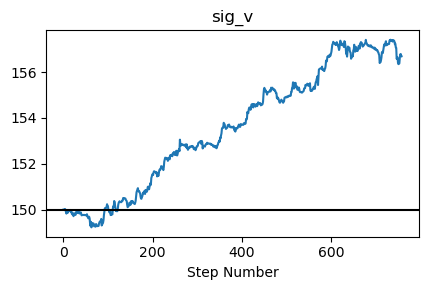

In [26]:
ncol = 4
nrow = int(np.ceil(len(names) / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3))
axs = np.atleast_2d(axs)
# for i in range(ncol):
    # axs[-1,i].set_xlabel('Step Number')
axs = axs.flatten()
for i in range(len(names)):
    axs[i].plot(steps, samples[i,:])
    axs[i].set_title(names[i])
    axs[i].axhline(truths[i], color='k')
    axs[i].set_xlabel('Step Number')
for i in range(len(names), len(axs)):
    axs[i].remove()
fig.tight_layout()
fig.savefig('../figs/trace.png')

if 'sigma8' in names and 'omega_m' in names:
    sigma8 = samples[names.index('sigma8')]
    omega_m = samples[names.index('omega_m')]

    config = configparser.ConfigParser()
    config.read(ini_name)
    omega_b = float(config['cosmology']['omega_b'])
    h = float(config['cosmology']['h100'])
    n_s = float(config['cosmology']['n_s'])
    A_s = 1.e-9 * symbolic_pofk.linear.sigma8_to_As(
            sigma8, omega_m, omega_b, h, n_s)
    print('A_s range:', A_s.min(), A_s.max())
    plt.figure()
    plt.hist(A_s)

Corner plot

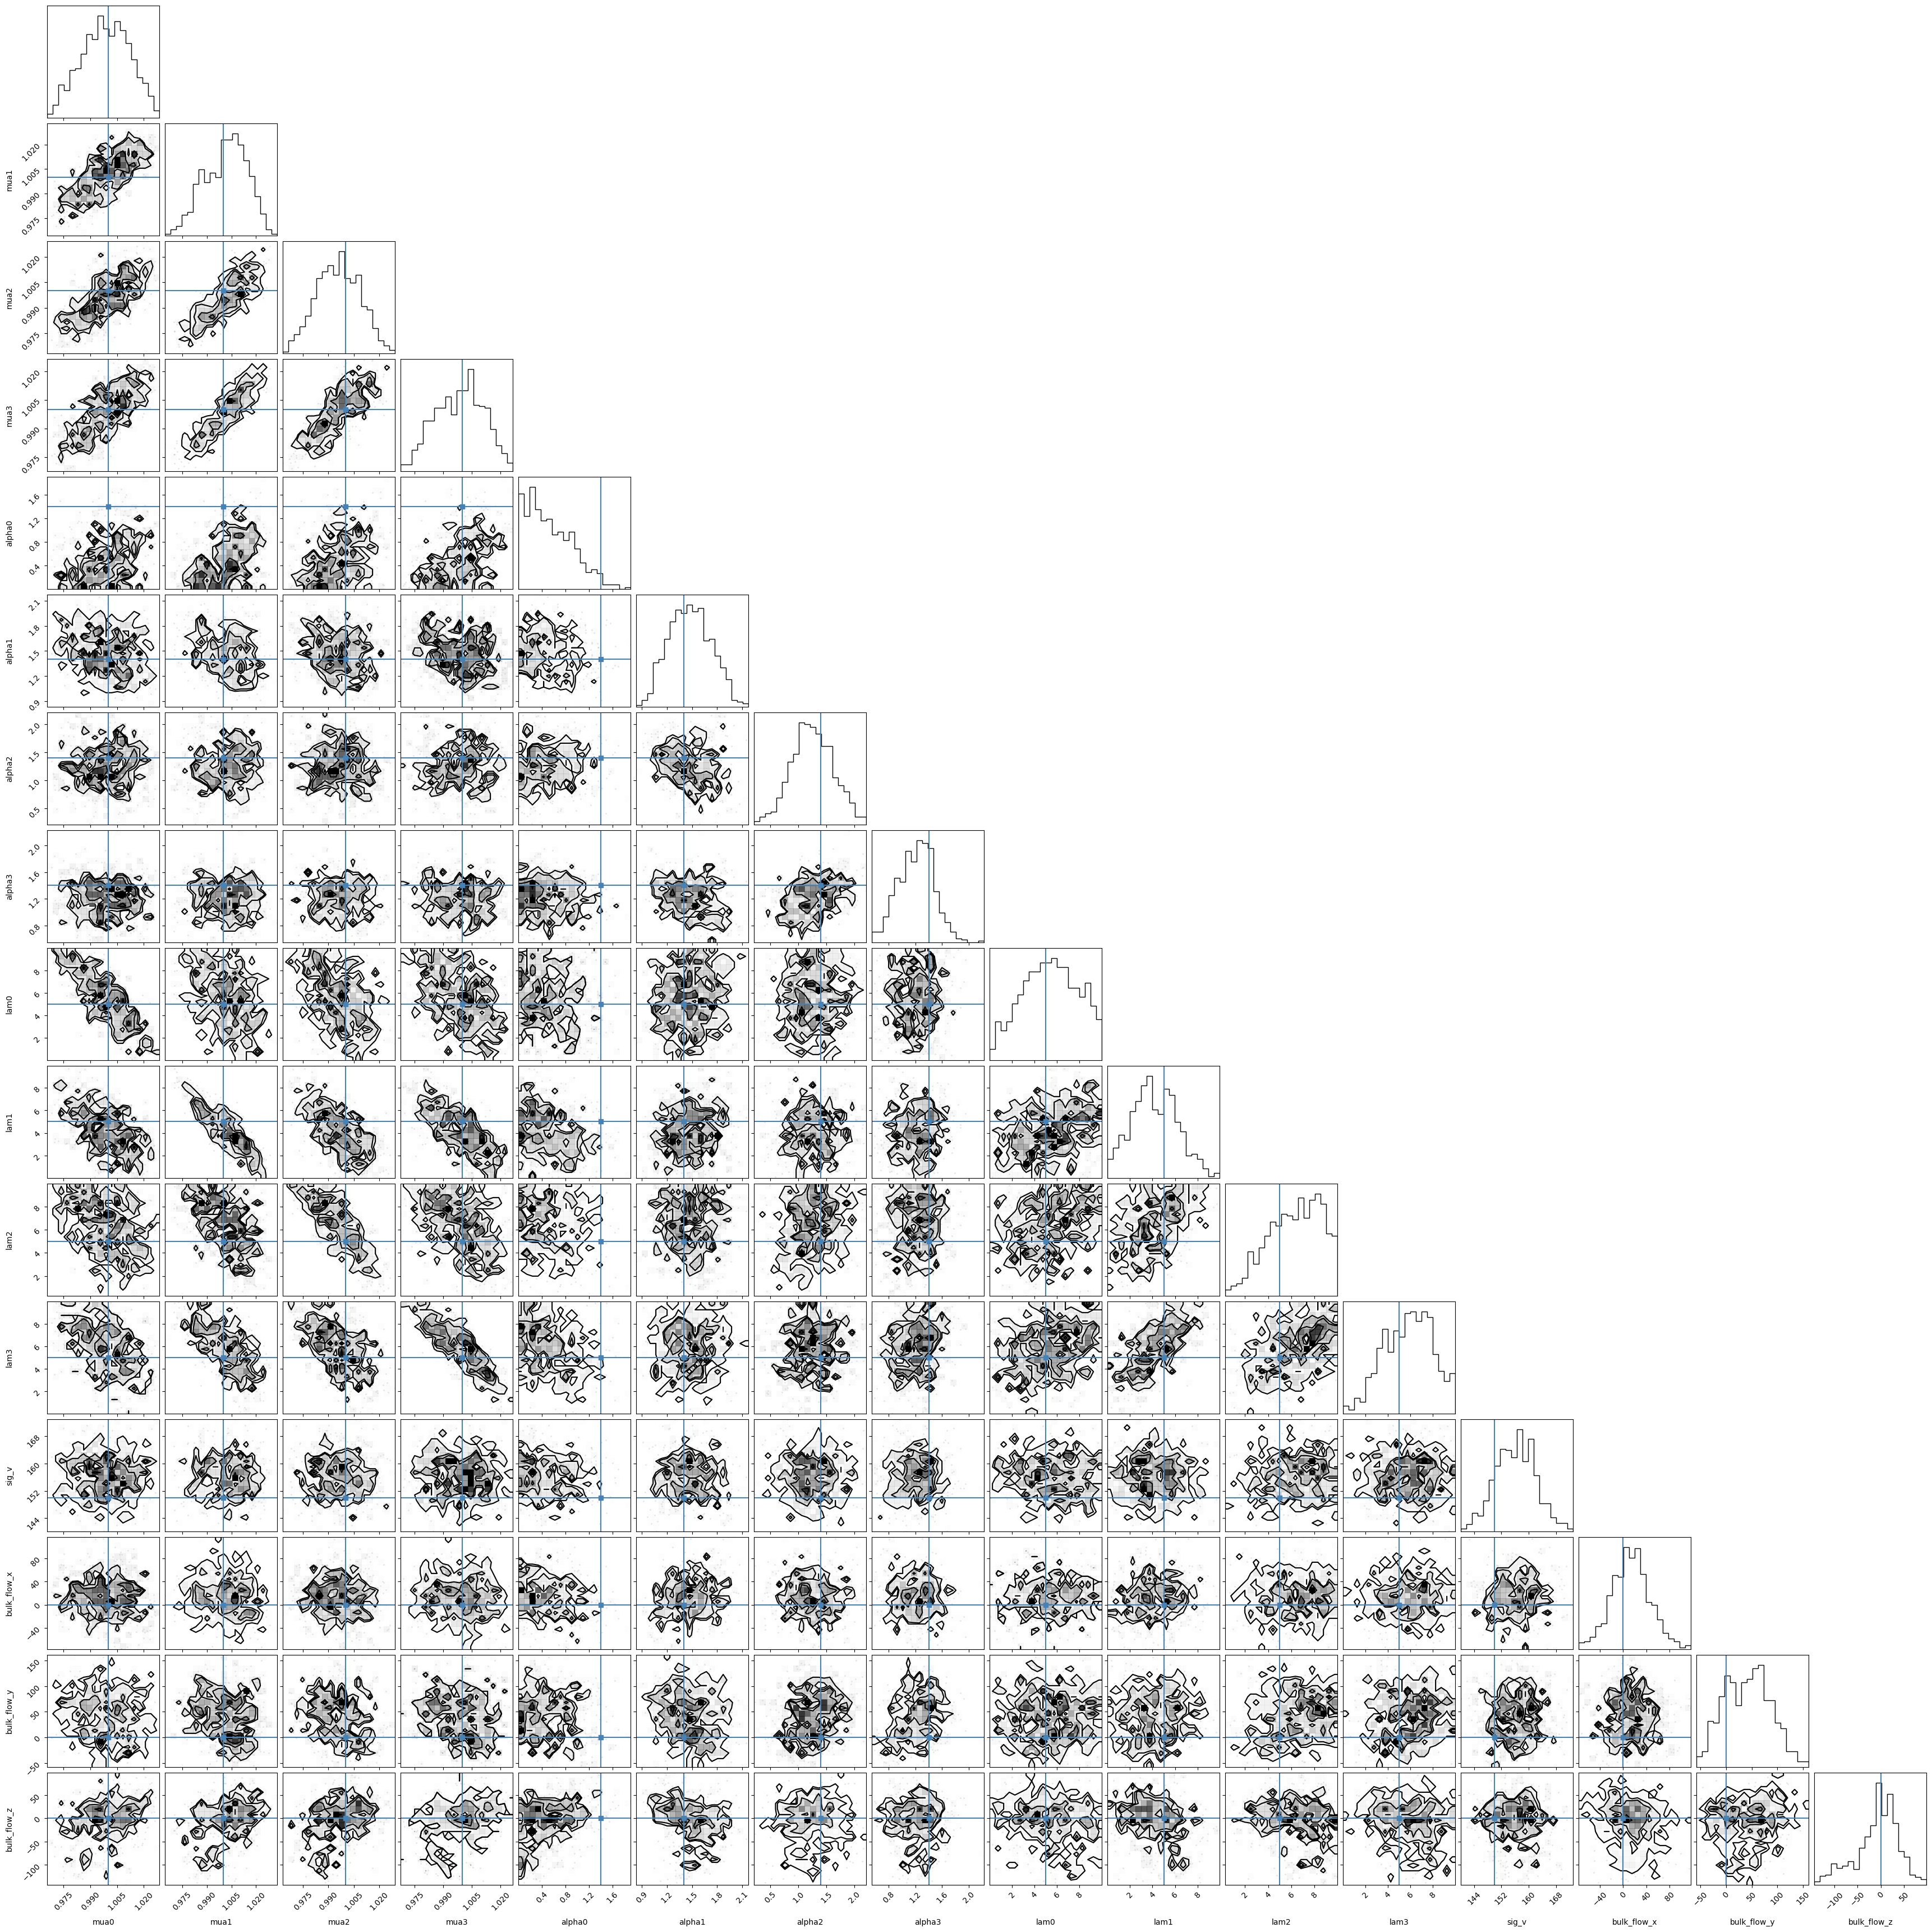

In [10]:
burn_in = 0
burn_in = 1000

m = steps > burn_in

# Full corner plot
corner.corner(
    samples[:,m].T,
    labels=names,
    truths=truths
);
fig = plt.gcf()
fig.savefig('../figs/corner_full.png', bbox_inches='tight', facecolor='white')

# Cosmology corner plot
if 'sigma8' in names and 'omega_m' in names:
    idx = np.array([names.index('sigma8'), names.index('omega_m')], dtype=int)
    corner.corner(
        samples[idx,m].T,
        labels=[names[i] for i in idx],
        truths=[truths[i] for i in idx]
    );
    fig = plt.gcf()
    fig.savefig('../figs/corner_cosmo.png', bbox_inches='tight', facecolor='white')

# Mock data

DENS -0.9808840727490473 17.530269738764385 -1.6263032587282567e-18 0.8490318268169118


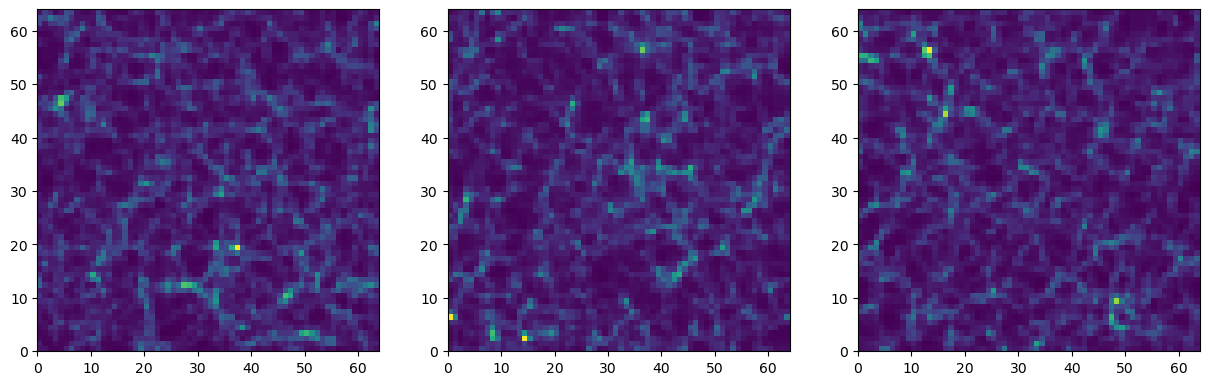

In [7]:
dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run_testing'
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_ics_N64_lam'

with h5.File(f'{dirname}/mock_data.h5', 'r') as f:
    dens = f['scalars/BORG_final_density'][:]
    print('DENS', dens.min(), dens.max(), dens.mean(), dens.std())

N = dens.shape[0]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].pcolor(dens[N//2])
axs[1].pcolor(dens[:,N//2,:])
axs[2].pcolor(dens[:,:,N//2])
for ax in axs:
    ax.set_aspect('equal')

# Analyse density fields

Computing ensemble mean field


100%|██████████| 104/104 [00:12<00:00,  8.02it/s]


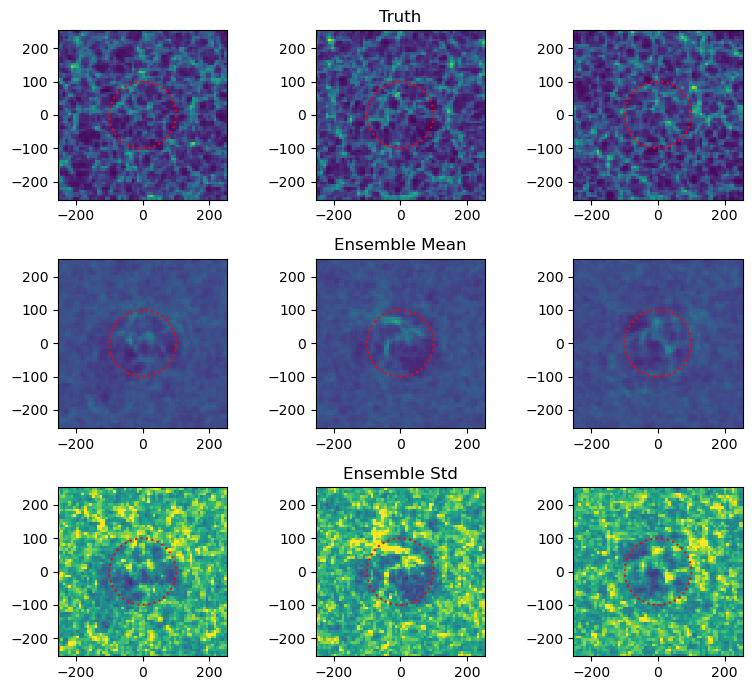

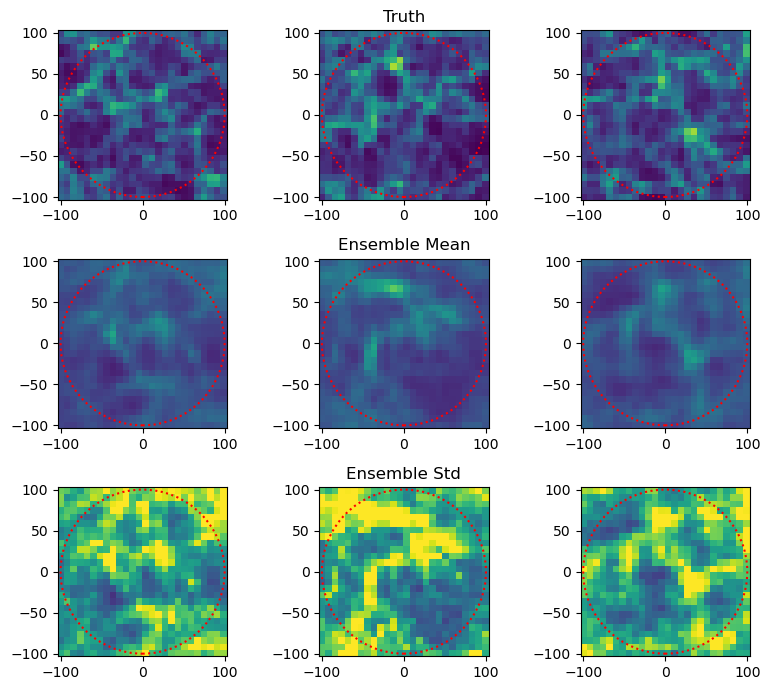

In [11]:
dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run_ic'; iter_max = 1748; iter_min = 0
ini_name = '../conf/basic_ini.ini'
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic_N64'; iter_max = -1; iter_min = 1000
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic'; iter_max = -1; iter_min = 1000
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_ics_N64_lam'; iter_max = -1; iter_min = 1000
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_N64_all'; iter_max = -1; iter_min = 1000
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v2'; iter_max = 1773; iter_min = 1000
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v3'; iter_max = 3509; iter_min = 1000
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_bf_prior'; iter_max = -1; iter_min = 1000
ini_name = f'{dirname}/ini_file.ini'
nframe = 100

all_true_delta = [None] * 2
all_mean_delta = [None] * 2
all_std_delta = [None] * 2

# Uncropped
all_true_delta[0], _ = get_mock_field(ini_name, dirname, cut_field=False)
all_mean_delta[0], all_std_delta[0] = compute_ensemble_mean_field(ini_name, dirname, nframe, iter_max, iter_min, cut_field=False)

# Cropped
all_true_delta[1], Lcrop = crop_field(ini_name, all_true_delta[0])
all_mean_delta[1], _ = crop_field(ini_name, all_mean_delta[0])
all_std_delta[1], _ = crop_field(ini_name, all_std_delta[0])

for cut_field in [False, True]:
    
    i = int(cut_field)
    true_delta = all_true_delta[i]
    mean_delta = all_mean_delta[i]
    std_delta = all_std_delta[i]

    fig, axs = plt.subplots(3, 3, figsize=(8,7))

    config = configparser.ConfigParser()
    config.read(ini_name)
    Rmax = float(config['mock']['R_max'])
    corner0 = float(config['system']['corner0'])
    L0 = float(config['system']['L0'])
    N0 = int(config['system']['N0'])
    x = np.linspace(corner0, corner0+L0, N0)
    if cut_field:
        m = np.abs(x) < Rmax
        x = x[m]

    for i, field in enumerate([np.log10(2+true_delta), np.log10(2+mean_delta), std_delta]):
        if i == 0:
            vmin = field.min()
            vmax = field.max()
        N = field.shape[0]
        j = N//2
        axs[i,0].pcolor(x, x, field[j], vmin=vmin, vmax=vmax)
        axs[i,1].pcolor(x, x, field[:,j,:], vmin=vmin, vmax=vmax)
        axs[i,2].pcolor(x, x, field[:,:,j], vmin=vmin, vmax=vmax)
        for ax in axs[i,:]:
            circle = plt.Circle((0, 0), Rmax, color='red', fill=False, linestyle='dotted', lw=1.5)
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            ax.add_patch(circle)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        for ax in axs[i,:]:
            ax.set_aspect('equal')

    axs[0,1].set_title('Truth')
    axs[1,1].set_title('Ensemble Mean')
    axs[2,1].set_title('Ensemble Std')
            
    fig.tight_layout()
    
    savename = '../figs/ensemble_mean'
    if cut_field:
        savename += '_cropped'
    savename += '.png'
    fig.savefig(savename, bbox_inches='tight', facecolor='w')

BOXSIZE 198.41269841269843

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.01 seconds


100%|██████████| 104/104 [00:14<00:00,  7.18it/s]


BOXSIZE 198.41269841269843

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


100%|██████████| 104/104 [00:07<00:00, 13.07it/s]


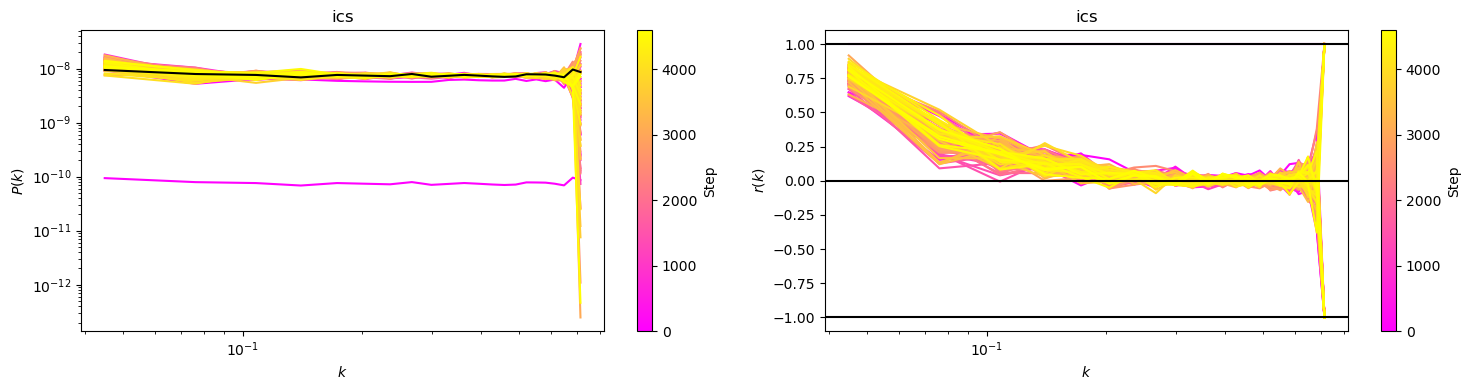

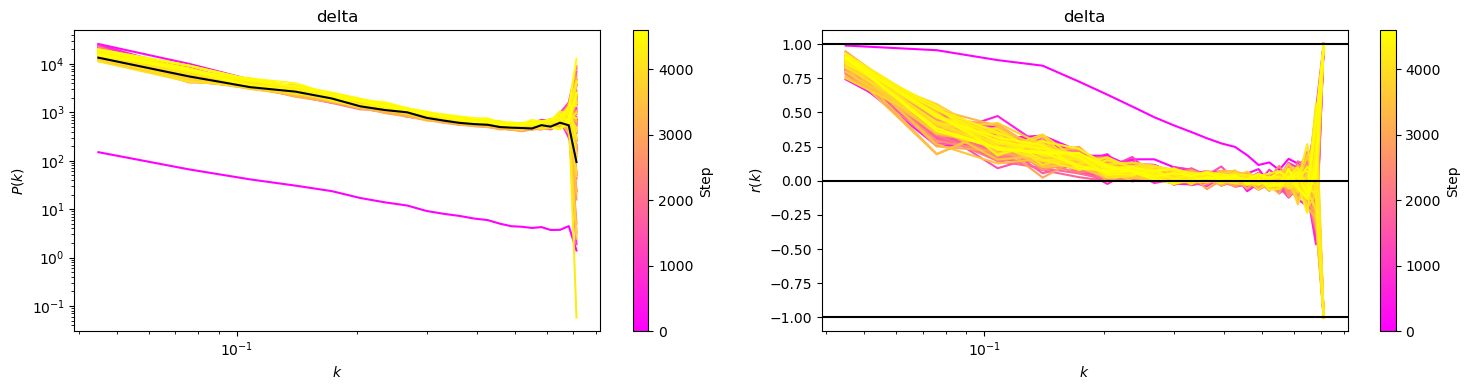

In [12]:
# ini_name = '../conf/basic_ini.ini'
# dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run_ic'; iter_max = 1748
# dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run_cosmo_model'; iter_max = 3780
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic'; iter_max = -1
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic_N64'; iter_max = -1
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_ics_N64_lam'; iter_max = -1
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_N64_all'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v2'; iter_max = 1773
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v3'; iter_max = 3509
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_bf_prior'; iter_max = -1

ini_name = f'{dirname}/ini_file.ini'
nframe = 100
iter_min = 0
# which_field = 'ics'
# which_field = 'delta'
cut_field = True
# cut_field = False

for which_field in ['ics', 'delta']:

    k, Pk_true, all_pk, all_r = get_spectra(ini_name, dirname, nframe, iter_max, iter_min, which_field=which_field, cut_field=cut_field)
    all_mcmc = get_mcmc_steps(dirname, nframe, iter_max, iter_min=iter_min)

    # Normalize the index for coloring
    norm = plt.Normalize(all_mcmc[0], all_mcmc[-1])
    cmap = plt.cm.spring  # Choose a colormap

    fig, axs = plt.subplots(1, 2, figsize=(15,4))

    # Plot Pk and r
    for i in range(all_pk.shape[0]):
        axs[0].loglog(k, all_pk[i, :], color=cmap(norm(all_mcmc[i])))
        axs[1].semilogx(k, all_r[i, :], color=cmap(norm(all_mcmc[i])))
    axs[0].loglog(k, Pk_true, color='k')
    for i in [-1, 0, 1]:
        axs[1].axhline(i, color='k')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    for ax in axs:
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Step')
        ax.set_title(which_field)
        ax.set_xlabel(r'$k$')
    axs[0].set_ylabel(r'$P(k)$')
    axs[1].set_ylabel(r'$r(k)$')
    fig.tight_layout()
    fig.savefig(f'../figs/spectra_{which_field}.png')

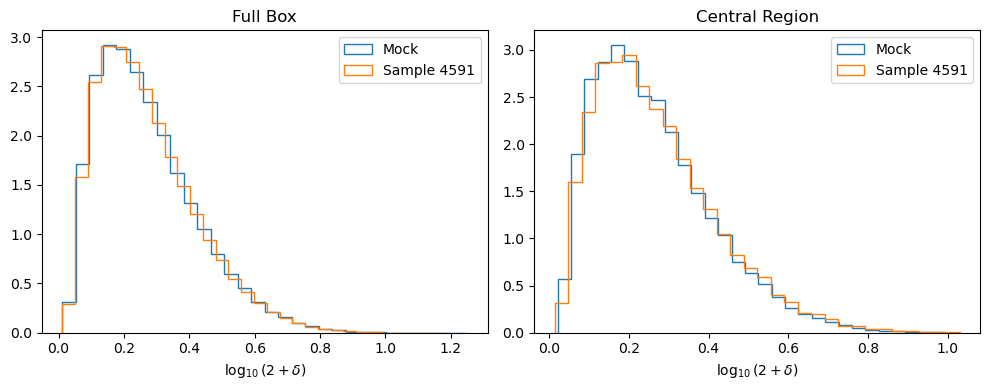

In [13]:
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic_N64'; step = 9554
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic'; step = 1860
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_ics_N64_lam'; step = 9624
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_N64_all'; step = 8609
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v2'; step = 1773
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v3'; step = 3509
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_bf_prior'; step = 4591
ini_name = f'{dirname}/ini_file.ini'
cut_field = True
cut_field = False

fig, axs = plt.subplots(1, 2, figsize=(10,4))

for cut_field in [False, True]:

    d1, d2 = get_both_fields(ini_name, dirname, step, which_field='delta', cut_field=cut_field)
    d1 = np.log10(2 + d1)
    d2 = np.log10(2 + d2)
    
    hist_kwargs = dict(bins=30, density=True, histtype='step')
    i = int(cut_field)
    axs[i].hist(d1.flatten(), label='Mock', **hist_kwargs)
    axs[i].hist(d2.flatten(), label='Sample %i'%step, **hist_kwargs)
    axs[i].legend()
    axs[i].set_xlabel(r'$\log_{10} (2 + \delta)$')
    
axs[0].set_title('Full Box')
axs[1].set_title('Central Region')
fig.tight_layout()
fig.savefig('../figs/density_histogram.png', bbox_inches='tight', facecolor='white')


# Plot likelihood as a function of step

  0%|          | 0/102 [00:00<?, ?it/s]/tmp/ipykernel_2378/3269883151.py:279: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_logL[i] = f['scalars/hmc_Elh'][:]
/tmp/ipykernel_2378/3269883151.py:280: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_logprior[i] = f['scalars/hmc_Eprior'][:]
100%|██████████| 102/102 [00:01<00:00, 67.49it/s]


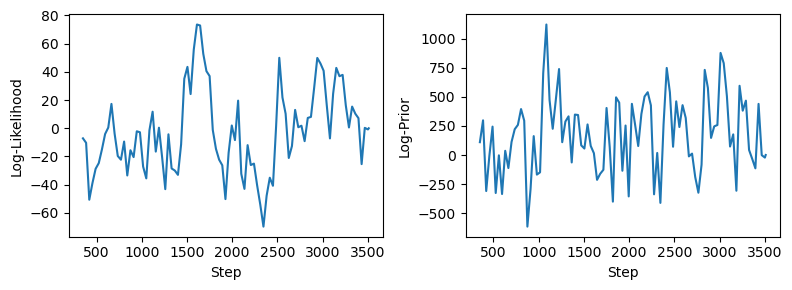

In [8]:
ini_name = '../conf/basic_ini.ini'
dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run_ic'; iter_max = 1748
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic_N64'; iter_max = 2421
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_ics_N64_lam'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_N64_all'; iter_max = -1
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v2'; iter_max = 1773
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic_v3'; iter_max = 3509
nframe = 100
iter_min = 0

all_mcmc = get_mcmc_steps(dirname, nframe, iter_max, iter_min=iter_min)
logL, logP = get_likelihood_values(dirname, nframe, iter_max, iter_min)
logL -= logL[-1]
logP -= logP[-1]

burnin = 10

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].plot(all_mcmc[burnin:], logL[burnin:], label='logL')
axs[1].plot(all_mcmc[burnin:], logP[burnin:], label='logPrior')
axs[0].set_ylabel('Log-Likelihood')
axs[1].set_ylabel('Log-Prior')
for ax in axs:
    ax.set_xlabel('Step')
fig.tight_layout()
fig.savefig('../figs/likelihood_trace.png', bbox_inches='tight', facecolor='white')

# Mock Data Plot

In [ ]:
# dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic'
dirname = '/data101/bartlett/fsigma8/borg_velocity/supranta_ics_N64_lam'
use_true = True
# use_true = False

ini_name = f'{dirname}/ini_file.ini'
config = configparser.ConfigParser()
config.read(ini_name)
nsamp = int(config['run']['nsamp'])
rmax = float(config['mock']['R_max'])
L = float(config['system']['L0'])
N = int(config['system']['N0'])

hist_kwargs = dict(bins=30, density=True, histtype='step')
scatter_kwargs = dict(marker='.', ms=1, lw=0)

fig, axs = plt.subplots(1, 4, figsize=(20,4))
fig2, axs2 = plt.subplots(1, 3, figsize=(15,4))
    
all_x = []

with h5.File(dirname + "/tracer_data_mock.h5",'r') as mcmc_file:
    for i in range(nsamp):
        if use_true:
            x = mcmc_file[f'sample_{i}/coord_true'][:]
        else:
            x = mcmc_file[f'sample_{i}/coord_meas'][:]
        all_x.append(x)
        r = np.sqrt(np.sum(x**2, axis=0))
        for j in range(3):
            axs[j].hist(x[j], **hist_kwargs)
        axs[-1].hist(r, label=f'Sample {i}', **hist_kwargs)
    
        axs2[0].plot(x[0], x[1], **scatter_kwargs)
        axs2[1].plot(x[1], x[2], **scatter_kwargs)
        axs2[2].plot(x[2], x[0], **scatter_kwargs)
        
for ax in axs2:
    ax.set_aspect('equal')    
    
fig3, axs3 = plt.subplots(1, 4, figsize=(15,4))
with h5.File(dirname + "/tracer_data_mock.h5",'r') as mcmc_file:
    for i in range(nsamp):
        xtrue = mcmc_file[f'sample_{i}/coord_true'][:]
        xmeas = mcmc_file[f'sample_{i}/coord_meas'][:]
        for j in range(3):
            axs3[j].plot(xtrue, xmeas, **scatter_kwargs)
        rtrue = np.sqrt(np.sum(xtrue**2, axis=0))
        rmeas = np.sqrt(np.sum(xmeas**2, axis=0))
        axs3[-1].plot(rtrue, rmeas, **scatter_kwargs)
    
# construct 3D counts field
all_x = np.hstack(all_x).T.astype(np.float32)
counts = np.zeros((N, N, N), dtype=np.float32)
MASL.MA(all_x, counts, L, 'CIC', verbose=True)
print(counts.shape)

plt.figure()
plt.pcolor(counts[N//2])



Using CIC mass assignment scheme
Time taken = 0.000 seconds

(64, 64, 64)


# Debug Underflow


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


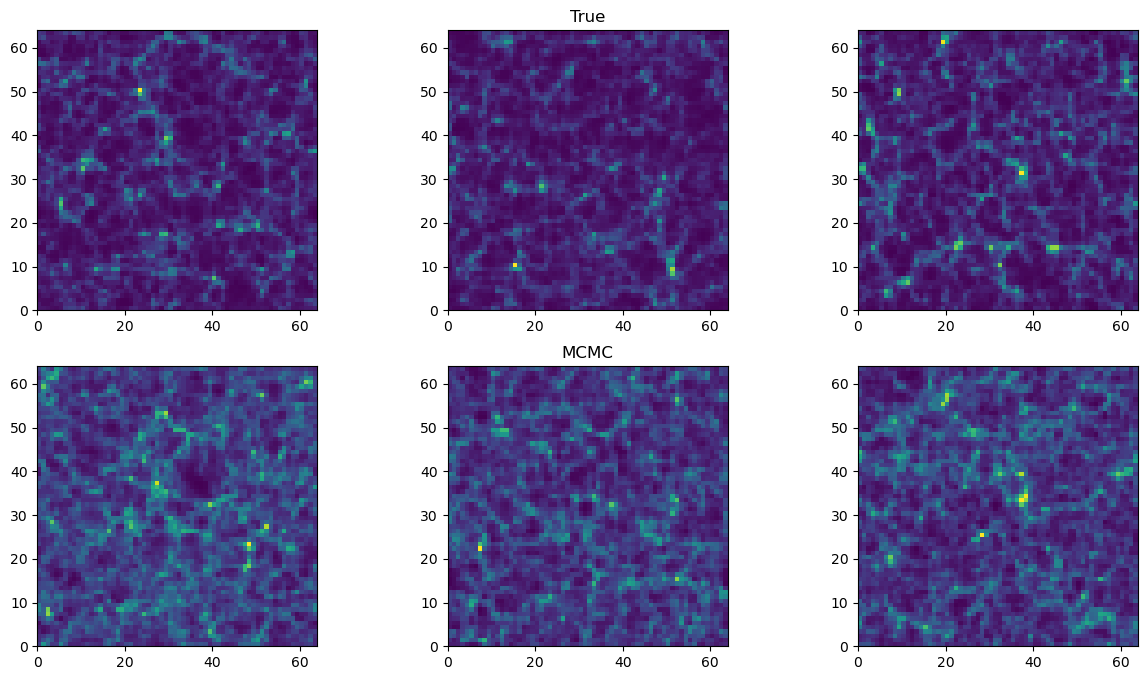

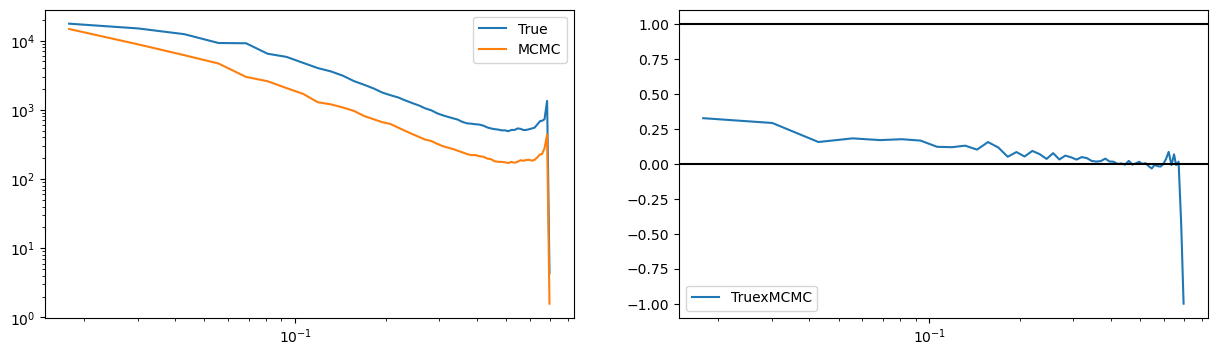

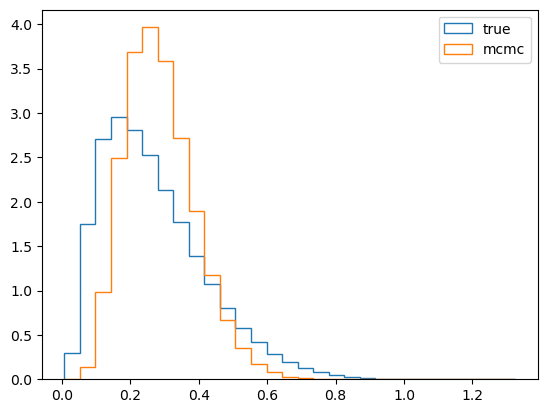

In [28]:
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic/'
boxsize = 500
MAS = "CIC"

with h5.File(f'{dirname}/mcmc_95.h5', 'r') as f:
    dens_mcmc = f['scalars/BORG_final_density'][:]
    
with h5.File(f'{dirname}/mock_data.h5', 'r') as f:
    dens_true = f['scalars/BORG_final_density'][:]
    
# Crop
# ini_name = f"{dirname}/ini_file.ini"
# dens_mcmc, boxsize = crop_field(ini_name, dens_mcmc)
# dens_true, boxsize = crop_field(ini_name, dens_true)
    
fig, axs = plt.subplots(2, 3, figsize=(15,8))

for i, f in enumerate([dens_true, dens_mcmc]):
    N = f.shape[0]
    axs[i,0].pcolor(f[:,:,N//2])
    axs[i,1].pcolor(f[:,N//2,:])
    axs[i,2].pcolor(f[N//2,:,:])
for ax in axs.flatten():
    ax.set_aspect('equal')
    
axs[0,1].set_title('True')
axs[1,1].set_title('MCMC')

Pk = PKL.XPk([dens_true.astype(np.float32),dens_mcmc.astype(np.float32)], boxsize, axis=0, MAS=[MAS, MAS], threads=1)
Pk0_1  = Pk.Pk[:,0,0]  #monopole of field 1
Pk0_2  = Pk.Pk[:,0,1]  #monopole of field 2
Pk0_X  = Pk.XPk[:,0,0] #monopole of 1-2 cross P(k)
k      = Pk.k3D
r = Pk0_X / np.sqrt(Pk0_1 * Pk0_2)

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].loglog(k, Pk0_1, label='True')
axs[0].loglog(k, Pk0_2, label='MCMC')
axs[1].semilogx(k, r, label='TruexMCMC')
for ax in axs:
    ax.legend()
for y in [0, 1]:
    axs[1].axhline(y, color='k')
    
    
fig, ax = plt.subplots(1, 1)
bins = np.linspace(np.log10(2 + min(dens_true.min(), dens_mcmc.min())), np.log10(2 + max(dens_true.max(), dens_mcmc.max())), 30) 
ax.hist(np.log10(2 + dens_true.flatten()), bins=bins, density=True, histtype='step', label='true')
ax.hist(np.log10(2 + dens_mcmc.flatten()), bins=bins, density=True, histtype='step', label='mcmc')
ax.legend()

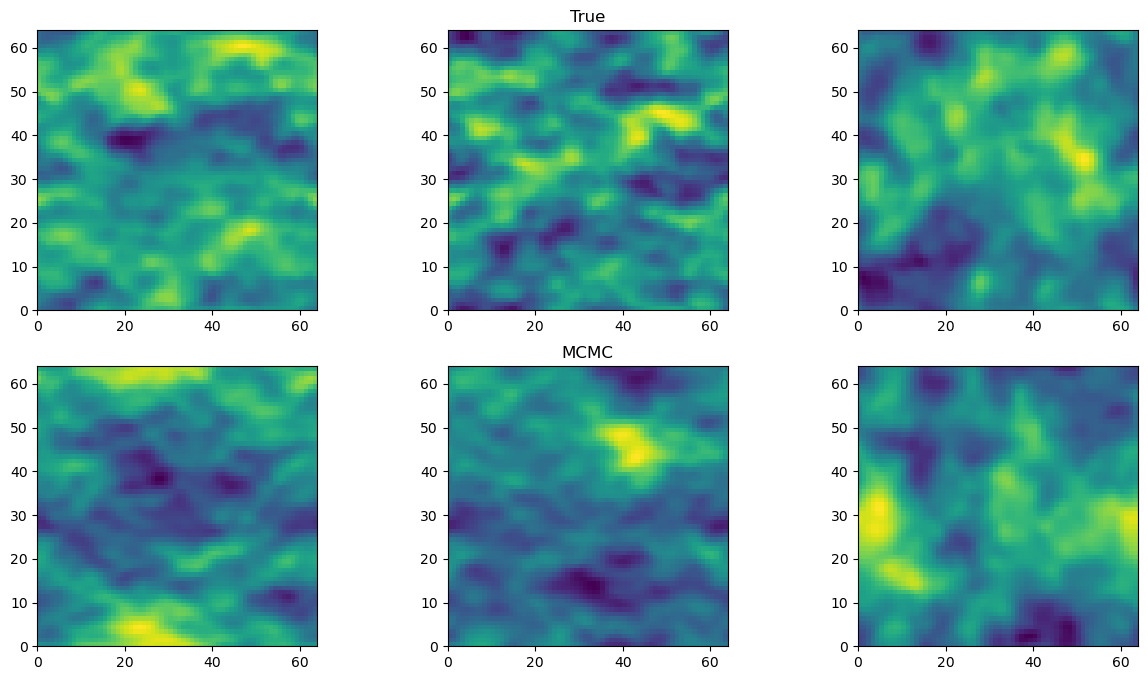

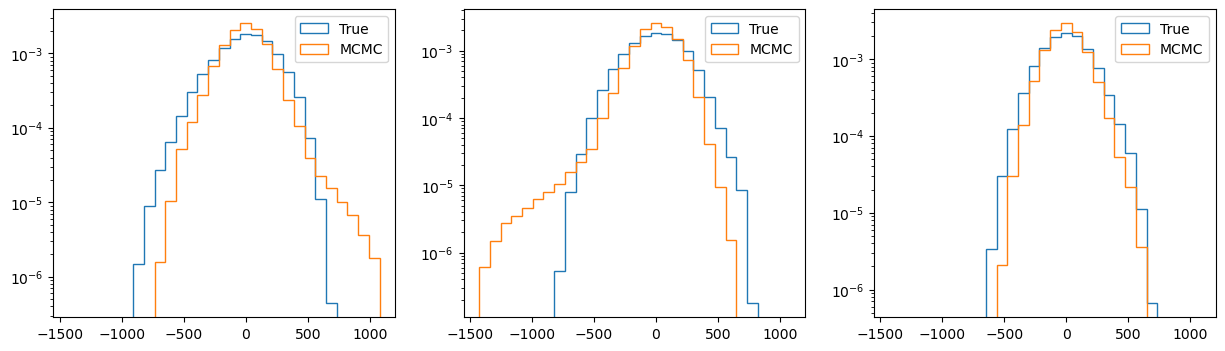

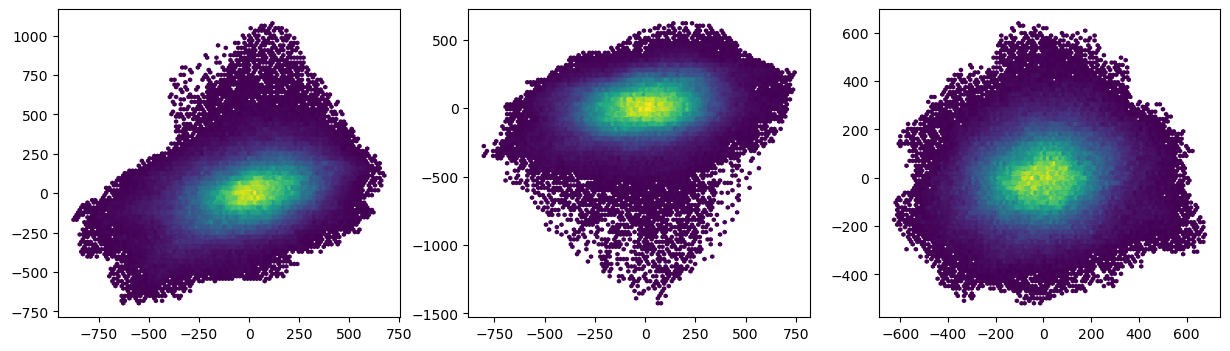

In [49]:
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic/'
component = 0

vel_true = np.load(f'{dirname}/mock_vel.npy')
vel_mcmc = np.load(f'{dirname}/mcmc_vel.npy')
    
fig, axs = plt.subplots(2, 3, figsize=(15,8))

for i, f in enumerate([vel_true, vel_mcmc]):
    N = f.shape[0]
    axs[i,0].pcolor(f[component,:,:,N//2])
    axs[i,1].pcolor(f[component,:,N//2,:])
    axs[i,2].pcolor(f[component,N//2,:,:])
for ax in axs.flatten():
    ax.set_aspect('equal')
    
axs[0,1].set_title('True')
axs[1,1].set_title('MCMC')

fig, axs = plt.subplots(1, 3, figsize=(15,4))
bins = np.linspace(min(vel_true.min(), vel_mcmc.min()), max(vel_true.min(), vel_mcmc.max()), 30)
for i in range(len(axs)):
    axs[i].hist(vel_true[i].flatten(), bins=bins, density=True, histtype='step', label='True')
    axs[i].hist(vel_mcmc[i].flatten(), bins=bins, density=True, histtype='step', label='MCMC')
    axs[i].legend()
    axs[i].set_yscale('log')
    
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for i in range(len(axs)):
    axs[i].hexbin(vel_true[i].flatten(), vel_mcmc[i].flatten(), mincnt=1)



192 [2.8885622 1.8333287]
976 [3.123437  2.7141156]
129 [1.9811783 1.97686  ]
282 [483.06342     2.1391425]
Worst: 3 282 483.06342
(3, 1225) (3, 1225)
0.15200306866613814
(1225,)
(1225,)
(1225,)
True position: [ 180.07121842 -249.22822852   96.67707877]
Measured r: [ 197.73909905 -273.68152333  106.16265399]
True vr: -269.32922
Observed cz: 32934.527
Largest true (abs) along each axis: [180.07121842 249.22822852 150.8314107 ]
Largest measured (abs) along each axis: [197.73909905 273.68152333 161.08961474]
(201,)
[ -26.74362669  -38.61752179 -147.64106462]


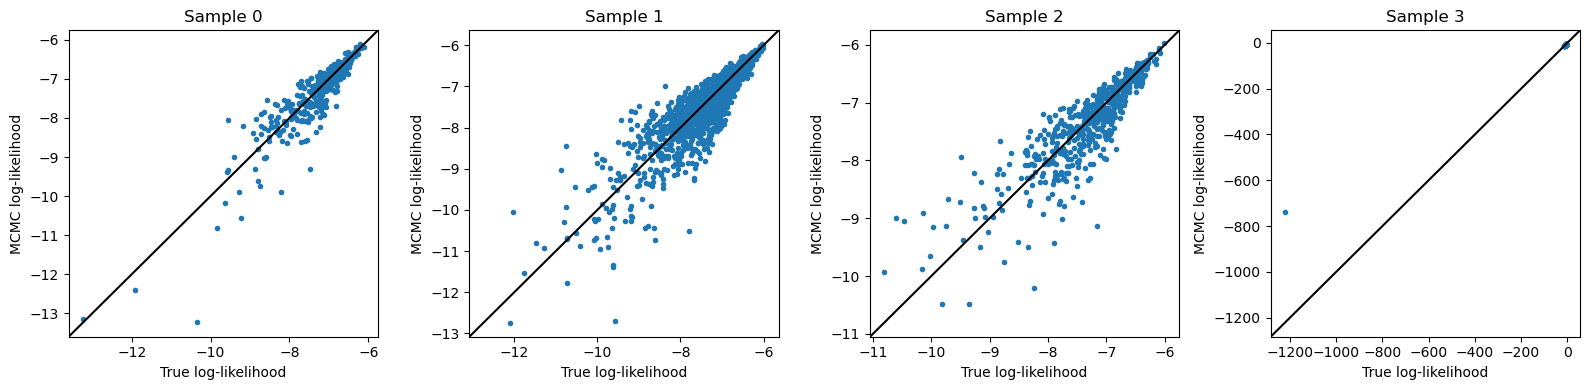

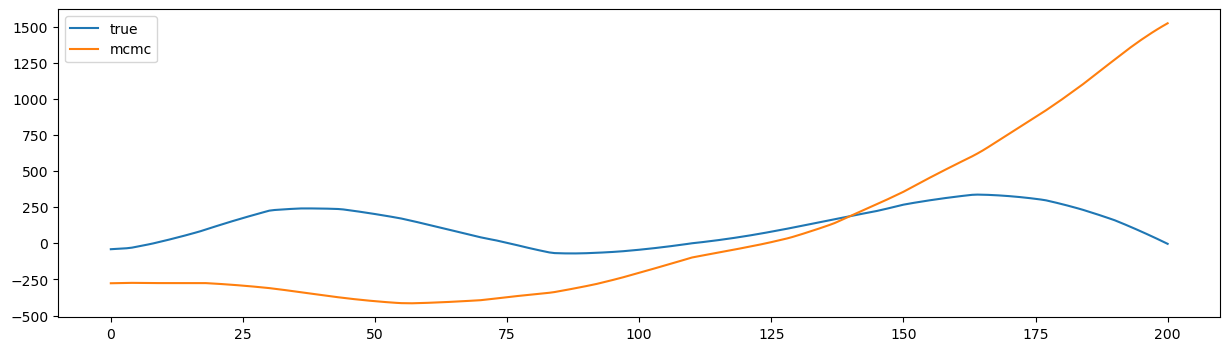

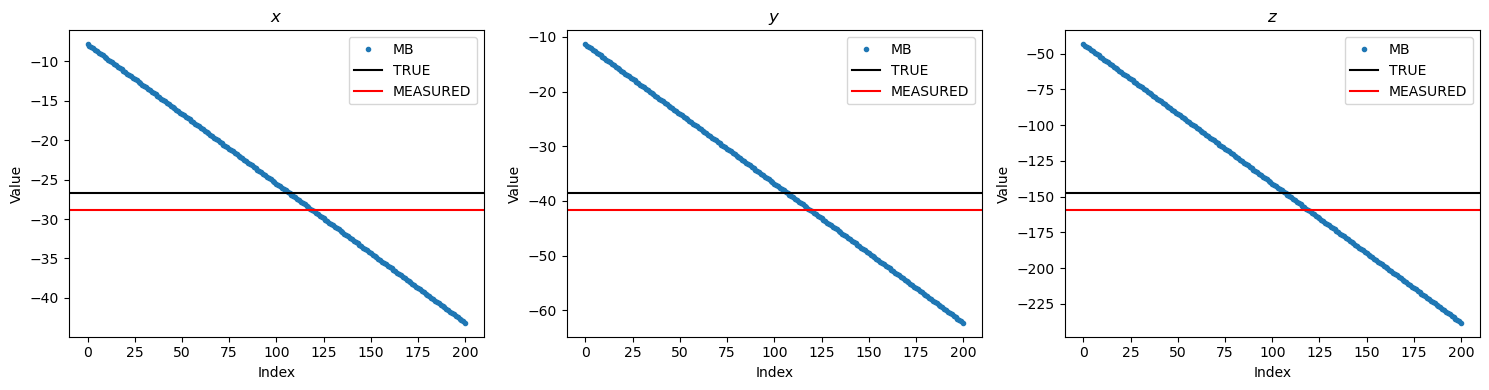

In [86]:
dirname = '/data101/bartlett/fsigma8/borg_velocity/blackjax_model_ic/'
component = 0

lkl_true = np.load(f'{dirname}/mock_lkl_ind.npz')
lkl_mcmc = np.load(f'{dirname}/mcmc_lkl_ind.npz')
nsamp = len(lkl_true.files)

samp_num = None
iworst = None
worst_diff = 0

fig, axs = plt.subplots(1, nsamp, figsize=(4*nsamp, 4))

for i in range(nsamp):
    xtrue = lkl_true[f'arr_{i}']
    xmcmc = lkl_mcmc[f'arr_{i}']
    axs[i].plot(xtrue, xmcmc, '.')
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    xlim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    axs[i].plot(xlim, xlim, color='k')
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(xlim)
    axs[i].set_xlabel('True log-likelihood')
    axs[i].set_ylabel('MCMC log-likelihood')
    axs[i].set_title(f'Sample {i}')
    
    # Get worst point
    diff = np.abs(xtrue - xmcmc)
    isort = np.argsort(-diff)
    if diff[isort[0]] > worst_diff:
        worst_diff = diff[isort[0]]
        samp_num = i
        iworst = isort[0]
    print(isort[0], diff[isort[:2]])    
fig.tight_layout()
fig.savefig('../figs/debug_logL.png', facecolor='white', bbox_inches='tight')
    
print('Worst:', samp_num, iworst, worst_diff)

# Find information on this tracer
with h5.File(f'{dirname}/tracer_data_mock.h5', 'r') as f:
    coord_true = np.array(f[f'sample_{samp_num}/coord_true'][:])
    coord_meas = np.array(f[f'sample_{samp_num}/coord_meas'][:])
    sig_mu = f[f'sample_{samp_num}/sig_mu'][()]
    vr_true = np.array(f[f'sample_{samp_num}/vr_true'][:])
    cz_obs = np.array(f[f'sample_{samp_num}/cz_obs'][:])
    r_hMpc = np.sqrt(np.sum(coord_meas ** 2, axis=0))
    print(coord_true.shape, coord_meas.shape)
    print(sig_mu)
    print(vr_true.shape)
    print(cz_obs.shape)
    print(r_hMpc.shape)
    
print('True position:', coord_true[:,iworst])
print('Measured r:', coord_meas[:,iworst])
print('True vr:', vr_true[iworst])
print('Observed cz:', cz_obs[iworst])

xmax = np.amax(np.abs(coord_true), axis=1)
print('Largest true (abs) along each axis:', xmax)
xmax = np.amax(np.abs(coord_meas), axis=1)
print('Largest measured (abs) along each axis:', xmax)

# Plot radial velocity for the worst tracer
vr_true = np.load(f'{dirname}/mock_tracer_vr.npz')[f'arr_{samp_num}'][iworst,:]
vr_mcmc = np.load(f'{dirname}/mcmc_tracer_vr.npz')[f'arr_{samp_num}'][iworst,:]
fig, ax = plt.subplots(1, 1, figsize=(15,4))
ax.plot(vr_true, label='true')
ax.plot(vr_mcmc, label='mcmc')
ax.legend()
print(vr_true.shape)

# Plot the MB positions for the worst tracer
itracer = iworst
itracer = 3
print(coord_true[:,itracer])
MB_pos = np.load(f'{dirname}/MB_pos.npz')[f'arr_{samp_num}'][:,itracer,:]
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for i in range(3):
    axs[i].plot(MB_pos[i], '.', label='MB')
    axs[i].axhline(coord_true[i,itracer], color='k', label='TRUE')
    axs[i].axhline(coord_meas[i,itracer], color='r', label='MEASURED')
    axs[i].legend()
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
axs[0].set_title(r'$x$')
axs[1].set_title(r'$y$')
axs[2].set_title(r'$z$')
fig.tight_layout()
# fig.savefig(f'../figs/MB_pos_{samp_num}_{itracer}.png', facecolor='white', bbox_inches='tight')

Use here to create warnings to implement in the code

7.269984374515526 210.9616513655193 (345,)
6.541561558252167 255.9753565156616 (1682,)
4.3919989345102 262.8841977513585 (556,)
5.479083286248933 353.9390295101536 (1225,)


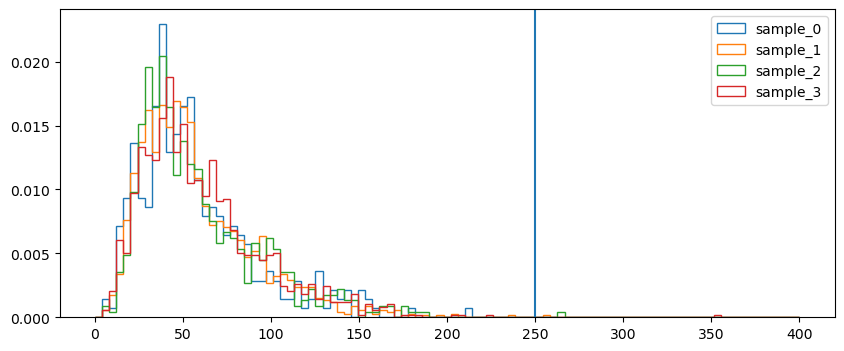

In [90]:
R_lim = 500 / 2

fig, ax = plt.subplots(1, 1, figsize=(10,4))
bins = np.linspace(0, 400, 100)

with h5.File(f'{dirname}/tracer_data_mock.h5', 'r') as f:
    for i in range(4):
        coord_true = np.array(f[f'sample_{i}/coord_true'][:])
        coord_meas = np.array(f[f'sample_{i}/coord_meas'][:])
        r_hMpc = np.sqrt(np.sum(coord_meas ** 2, axis=0))
        ax.hist(r_hMpc, bins=bins, density=True, histtype='step', label=f'sample_{i}')
        m = r_hMpc > R_lim
        print(i, m.sum())
ax.legend()
ax.axvline(R_lim)